In [3]:
!pip install -qq transformers

     |████████████████████████████████| 2.6 MB 4.9 MB/s 
     |████████████████████████████████| 3.3 MB 34.9 MB/s 
     |████████████████████████████████| 895 kB 36.7 MB/s 
     |████████████████████████████████| 636 kB 47.4 MB/s 


In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
from tqdm import tqdm 
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
!nvidia-smi

Thu Aug  5 06:22:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [7]:
path = '/content/drive/MyDrive/aidea_sentiment_analysis'

imdb_data = pd.read_csv(f'{path}/data/processed_train.csv')
imdb_test_data = pd.read_csv(f'{path}/data/processed_test.csv')

materials = pd.read_csv(f'{path}/materials/IMDB_Dataset.csv')

In [ ]:
imdb_data

,ID,review,sentiment,processed_review,pruned_review
0,41411,I watched this film because I'm a big fan of R...,0,watch film m big fan river phoenix joaquin pho...,river phoenix joaquin phoenix embarrasing weir...
1,37586,It does not seem that this movie managed to pl...,1,movie manage lot people see place bump acciden...,usually great crazy pretty mr jones different ...
2,6017,"Enough is not a bad movie , just mediocre .",0,bad movie mediocre,bad mediocre
3,44656,my friend and i rented this one a few nights a...,0,friend rent night ago single good movie see me...,ago single good close wonderfuly original usua...
4,38711,"Just about everything in this movie is wrong, ...",0,movie wrong wrong wrong mike myers example s r...,wrong wrong myers ago cutesy painfully unfunny...
...,...,...,...,...,...
29336,8019,It 's one of the most honest films ever made a...,1,s honest film hollywood,honest hollywood
29337,453,An absorbing and unsettling psychological drama .,1,absorb unsettling psychological drama,absorb unsettling psychological
29338,13097,"Soylent Green IS...a really good movie, actual...",1,soylent green good movie actually ve think don...,soylent green good actually heston sneery invi...
29339,26896,There just isn't enough here. There a few funn...,0,isn funny spot disappoint love stupid movie ex...,isn funny stupid good loud maybe funny flat ma...


In [ ]:
imdb_test_data

,ID,review,sentiment,processed_review,pruned_review,pred_sentiment,score
0,41411,I watched this film because I'm a big fan of R...,0,watch film m big fan river phoenix joaquin pho...,river phoenix joaquin phoenix embarrasing weir...,0,0.984501
1,37586,It does not seem that this movie managed to pl...,1,movie manage lot people see place bump acciden...,usually great crazy pretty mr jones different ...,1,0.999685
2,6017,"Enough is not a bad movie , just mediocre .",0,bad movie mediocre,bad mediocre,0,0.999798
3,44656,my friend and i rented this one a few nights a...,0,friend rent night ago single good movie see me...,ago single good close wonderfuly original usua...,1,0.999860
4,38711,"Just about everything in this movie is wrong, ...",0,movie wrong wrong wrong mike myers example s r...,wrong wrong myers ago cutesy painfully unfunny...,0,0.973535
...,...,...,...,...,...,...,...
29299,8019,It 's one of the most honest films ever made a...,1,s honest film hollywood,honest hollywood,1,0.999783
29300,453,An absorbing and unsettling psychological drama .,1,absorb unsettling psychological drama,absorb unsettling psychological,0,0.854891
29301,13097,"Soylent Green IS...a really good movie, actual...",1,soylent green good movie actually ve think don...,soylent green good actually heston sneery invi...,1,0.997482
29302,26896,There just isn't enough here. There a few funn...,0,isn funny spot disappoint love stupid movie ex...,isn funny stupid good loud maybe funny flat ma...,0,0.997078


In [8]:
materials

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## Some preprocessing

In [ ]:
# filtered weird sentiment data
imdb_data = imdb_data[~imdb_data['sentiment'].str.contains(r'[^0-9]')]

In [ ]:
imdb_data

,ID,review,sentiment,processed_review,pruned_review
0,41411,I watched this film because I'm a big fan of R...,0,watch film m big fan river phoenix joaquin pho...,river phoenix joaquin phoenix embarrasing weir...
1,37586,It does not seem that this movie managed to pl...,1,movie manage lot people see place bump acciden...,usually great crazy pretty mr jones different ...
2,6017,"Enough is not a bad movie , just mediocre .",0,bad movie mediocre,bad mediocre
3,44656,my friend and i rented this one a few nights a...,0,friend rent night ago single good movie see me...,ago single good close wonderfuly original usua...
4,38711,"Just about everything in this movie is wrong, ...",0,movie wrong wrong wrong mike myers example s r...,wrong wrong myers ago cutesy painfully unfunny...
...,...,...,...,...,...
29336,8019,It 's one of the most honest films ever made a...,1,s honest film hollywood,honest hollywood
29337,453,An absorbing and unsettling psychological drama .,1,absorb unsettling psychological drama,absorb unsettling psychological
29338,13097,"Soylent Green IS...a really good movie, actual...",1,soylent green good movie actually ve think don...,soylent green good actually heston sneery invi...
29339,26896,There just isn't enough here. There a few funn...,0,isn funny spot disappoint love stupid movie ex...,isn funny stupid good loud maybe funny flat ma...


In [ ]:
imdb_data['sentiment'] = imdb_data['sentiment'].astype(np.int8)
imdb_data['pruned_review'] = imdb_data['pruned_review'].astype(str)

imdb_data.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Set params

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

BATCH_SIZE = 32

num_labels = len(imdb_data['sentiment'].unique())

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

## Choose MAX_LENGTH for BERT

In [ ]:
all_review = list(map(str, np.concatenate([imdb_data.pruned_review.values, imdb_test_data.pruned_review.values])))

In [ ]:
token_lens = []

for txt in tqdm(all_review):
    # handle not vaild input issue
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

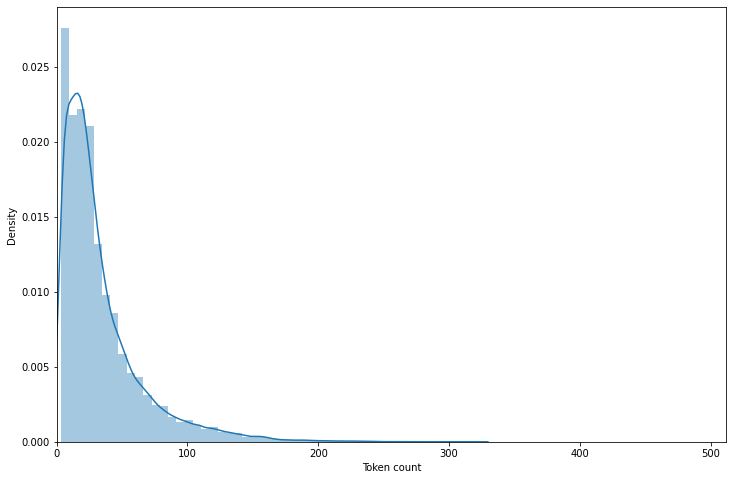

In [ ]:
# plot distribution of length 
sns.distplot(token_lens)
plt.xlim([0, 512])
plt.xlabel('Token count')
plt.ylabel('Density')

In [ ]:
MAX_LEN = 350

## Create pytorch Dataset

Returns
* review_text
* input_ids
* attention_mask
* targets

In [ ]:
class IMDB_Dataset(Dataset): # inherit from pytorch Dataset class.

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index): # if you want to get item via index like a list that you needs to define '__getitem__' method
        review = self.reviews[index] 
        target = self.targets[index]
        
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text = review,  # Preprocess sentence
            add_special_tokens = True,        # Add `[CLS]` and `[SEP]`
            max_length = self.max_len,                  # Max length to truncate/pad
            padding = 'max_length',         # Pad sentence to max length
            return_tensors = 'pt',           # Return PyTorch tensor
            return_attention_mask = True      # Return attention mask
            )

        return {
            'review_text' : review,
            'input_ids' : encoded_sent['input_ids'].flatten(), # padding 0 horizontally to transform tensor (1, MAX_LEN) 
            'attention_mask' : encoded_sent['attention_mask'].flatten(), # padding 0 horizontally to transform tensor (1, MAX_LEN) 
            'targets' : torch.tensor(target, dtype=torch.long)
        }

In [ ]:
train_df, val_df = train_test_split(imdb_data, test_size=0.2, random_state=75)
print(train_df.shape, val_df.shape)

(23442, 5) (5861, 5)


In [ ]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [ ]:
train_dataset = IMDB_Dataset(train_df.pruned_review, train_df.sentiment, tokenizer, MAX_LEN)
val_dataset = IMDB_Dataset(val_df.pruned_review, val_df.sentiment, tokenizer, MAX_LEN)

In [ ]:
train_dataset[5]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0

## Wrapping Dataset with DataLoader
dataloader can be ragarded as a wrapped iterator for bucketize dataset to mini batches  

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset,  batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,  batch_size=BATCH_SIZE, shuffle=True)

## Example for raw BERT usage

BERT has two kinds output 
  * pooler output : mostly used, for classification and regression
  * sequence output : for NLI (Natural Language Interaction)

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
s = 'Congratulations!That is a such great news for you!'
encoding = tokenizer.encode_plus(
    text = s,  # Preprocess sentence
    add_special_tokens = True,        # Add `[CLS]` and `[SEP]`
    max_length = 20,                  # Max length to truncate/pad
    padding = 'max_length',         # Pad sentence to max length
    return_tensors = 'pt',           # Return PyTorch tensor
    return_attention_mask = True      # Return attention mask
    )

In [ ]:
o = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  output_hidden_states=True,
  output_attentions=True
)

print('I am a cool object and you can access my elements with o.last_hidden_state, o["last_hidden_state"] or even o[0]. My keys are: {} '.format(o.keys()))
print('last hidden state shape : {}'.format(o.last_hidden_state.shape))

I am a cool object and you can access my elements with o.last_hidden_state, o["last_hidden_state"] or even o[0]. My keys are: odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions']) 
last hidden state shape : torch.Size([1, 20, 768])


In [ ]:
o['last_hidden_state'][:, 0, :].shape

torch.Size([1, 768])

## Define BERT Classifier architecture

If we want to get classified prediction from BERT, except raw BERT model, we needs to define a **Feed-Forward Neural Network** and dense layer additionally. 

In [ ]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, n_classes, freeze_bert=True):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()

        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, n_classes

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model, to freeze part of your model and train the rest
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        # output = self.drop(outputs.pooler_output)
        # output = self.out(outputs)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs['last_hidden_state'][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [ ]:
# class BERTGRUSentiment(nn.Module):
#     def __init__(self,
#                  hidden_dim,
#                  output_dim,
#                  n_layers,
#                  bidirectional,
#                  dropout):
        
#         super().__init__()
        
#         self.bert = BertModel.from_pretrained('bert-base-uncased')
        
#         embedding_dim = self.bert.config.to_dict()['hidden_size']
        
#         self.rnn = nn.GRU(embedding_dim,
#                           hidden_dim,
#                           num_layers = n_layers,
#                           bidirectional = bidirectional,
#                           batch_first = True,
#                           dropout = 0 if n_layers < 2 else dropout)
        
#         self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
#         self.dropout = nn.Dropout(dropout)
        
#     def forward(self, text):
        
#         #text = [batch size, sent len]
                
#         with torch.no_grad():
#             embedded = self.bert(text)[0]
                
#         #embedded = [batch size, sent len, emb dim]
        
#         _, hidden = self.rnn(embedded)
        
#         #hidden = [n layers * n directions, batch size, emb dim]
        
#         if self.rnn.bidirectional:
#             hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
#         else:
#             hidden = self.dropout(hidden[-1,:,:])
                
#         #hidden = [batch size, hid dim]
        
#         output = self.out(hidden)
        
#         #output = [batch size, out dim]
        
#         return output

## BERT Classifier Usage Example (without fine-tuning)

In [ ]:
model = BertClassifier(num_labels, freeze_bert=True)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([1, 20])
torch.Size([1, 20])


In [ ]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

classifier.0.weight
classifier.0.bias
classifier.2.weight
classifier.2.bias


## Optimizer & Learning Rate Scheduler

Optimizer is for fine-tune BERT Classifier, the authors recommend following hyper-parameters:

* Batch size: 16 or 32 
* Learning rate (Adam): 5e-5, 3e-5 or 2e-5 
* Number of epochs: 2, 3, 4


What is Optimizer?

![](https://forums.fast.ai/uploads/default/original/1X/43a48f3ba8b0ace15c574f3a20a31e8eaf1396ed.png)

In [ ]:
from transformers import BertConfig, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(n_classes, epochs):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    # bert_classifier = BertClassifier(n_classes, freeze_bert=True)
    
    config = BertConfig.from_pretrained("bert-base-uncased", num_labels=num_labels)
    bert_classifier = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                                    config=config)
    for param in bert_classifier.base_model.parameters():
      param.requires_grad = False

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    
                      eps=1e-5,
                      correct_bias=False    
                      )

    loss_fn = nn.CrossEntropyLoss().to(device)

    bert_classifier = bert_classifier.to(device)
    loss_fn = loss_fn.to(device)

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                          num_warmup_steps=0, 
                          num_training_steps=total_steps)
    
    return bert_classifier, optimizer, scheduler, loss_fn

In [ ]:
bert_classifier, optimizer, scheduler, loss_fn = initialize_model(num_labels, epochs=4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Define metric 
for calculating accuracy and evaluation that applied on training and evaluation epochs

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def binary_accuracy(preds, y):
  
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
flat_accuracy(np.array([[0, 1]]), np.array([[1, 1]]))

1.0

In [ ]:
def train(bert_classifier, train_dataloader, optimizer, scheduler):
    
  num_training_steps = 1 * len(train_dataloader)

  progress_bar = tqdm(range(num_training_steps))

  total_train_loss = []
  total_train_accuracy = 0

  size = len(train_dataloader)
  
  model.train()
    
  for batch in train_dataloader:

    optimizer.zero_grad() # clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).

    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    targets = batch["targets"].to(device)

    outputs = bert_classifier(input_ids, 
                attention_mask=attention_mask, 
                labels=targets)

    loss, logits = outputs.loss, outputs.logits

    predictions = torch.argmax(logits, dim=-1)

    total_train_accuracy += binary_accuracy(predictions, targets)

    total_train_loss.append(loss.detach().cpu().numpy())

    loss.backward() # start backpropagation, derivative of the parameters

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip the norm of the gradients to 1.0 to prevent "exploding gradients"

    optimizer.step() # update parameters and the learning rate
    scheduler.step()

    progress_bar.update(1)

        
  return total_train_accuracy / size, np.mean(np.array(total_train_loss))

In [ ]:
def eval_model(bert_classifier, val_dataloader, optimizer, scheduler):
    
  num_validation_steps = 1 * len(val_dataloader)

  progress_bar = tqdm(range(num_validation_steps))

  total_val_loss = []
  total_val_accuracy = 0

  size = len(val_dataloader)
  
  bert_classifier.eval()

  for batch in val_dataloader:

    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    targets = batch["targets"].to(device)

    with torch.no_grad(): # just for inference
      outputs = bert_classifier(input_ids, 
                    attention_mask=attention_mask, 
                    labels=targets)
      
    loss, logits = outputs.loss, outputs.logits

    predictions = torch.argmax(logits, dim=-1)

    total_val_accuracy += binary_accuracy(predictions, targets)

    total_val_loss.append(loss.detach().cpu().numpy())

    progress_bar.update(1)

        
  return total_val_accuracy / size, np.mean(np.array(total_val_loss))

In [ ]:
%%time

from collections import defaultdict

history = defaultdict(list)
EPOCHS = 4 
best_accuracy = 0

for epoch in tqdm(range(EPOCHS)):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train(bert_classifier, train_dataloader, optimizer, scheduler)
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(bert_classifier, val_dataloader, optimizer, scheduler)
  print(f'Val   loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------


Train loss 0.6674918532371521 accuracy 0.6092731952667236


Val   loss 0.6530554294586182 accuracy 0.6536345481872559
Epoch 2/4
----------


Train loss 0.6466750502586365 accuracy 0.6627681255340576


Val   loss 0.6417297720909119 accuracy 0.671637237071991
Epoch 3/4
----------


Train loss 0.6382255554199219 accuracy 0.6734879612922668


Val   loss 0.6362980604171753 accuracy 0.6735054850578308
Epoch 4/4
----------


Train loss 0.6346789002418518 accuracy 0.675771176815033


Val   loss 0.6346945762634277 accuracy 0.67629075050354

CPU times: user 48min 8s, sys: 8.25 s, total: 48min 16s
Wall time: 48min 17s


In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# %%time

# num_epochs = 1

# num_training_steps = num_epochs * len(train_dataloader)

# progress_bar = tqdm(range(num_training_steps))
# # def train_and_eval(model, dataloader, optimizer, scheduler, loss_fn):

# bert_classifier.train()

# for epoch in range(num_training_steps):

#   total_train_accuracy = 0
#   total_val_accuracy = 0

#   total_train_loss = 0
#   total_val_loss = 0


#   for batch in train_dataloader:

#     optimizer.zero_grad() # clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).

#     input_ids = batch["input_ids"].to(device)
#     attention_mask = batch["attention_mask"].to(device)
#     targets = batch["targets"].to(device)

#     outputs = bert_classifier(input_ids, 
#                 attention_mask=attention_mask, 
#                 labels=targets)

#     loss, logits = outputs.loss, outputs.logits

#     predictions = torch.argmax(logits, dim=-1)

#     total_train_accuracy += binary_accuracy(predictions, targets)

#     total_train_loss.append(loss)

#     loss.backward() # start backpropagation, derivative of the parameters

#     torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip the norm of the gradients to 1.0 to prevent "exploding gradients"

#     optimizer.step() # update parameters and the learning rate
#     scheduler.step()

#     progress_bar.update(1)


#   bert_classifier.eval()

#   for batch in val_dataloader:

#     input_ids = batch["input_ids"].to(device)
#     attention_mask = batch["attention_mask"].to(device)
#     targets = batch["targets"].to(device)

#     with torch.no_grad(): # just for inference
#     # outputs = model(
#       #   input_ids=input_ids,
#       #   attention_mask=attention_mask
#       # )
#       # outputs = model(batch['review_text']).squeeze(1)
#       outputs = bert_classifier(input_ids, 
#                     attention_mask=attention_mask, 
#                     labels=targets)
      
#     loss, logits = outputs.loss, outputs.logits

#     predictions = torch.argmax(logits, dim=-1)

#     total_val_accuracy += binary_accuracy(predictions, targets)

#     total_val_loss.append(loss)

# print(train_acc)
# print(val_acc)

In [ ]:
# %%time
# from collections import defaultdict

# history = defaultdict(list)
# EPOCHS = 4
# best_accuracy = 0

# for epoch in range(EPOCHS):
#   print(f'Epoch {epoch + 1}/{EPOCHS}')
#   print('-' * 10)

#   train_acc, train_loss = train(bert_classifier, train_dataloader, optimizer, scheduler, loss_fn)
#   print(f'Train loss {train_loss} accuracy {train_acc}')

#   val_acc, val_loss = eval_model(bert_classifier, val_dataloader, loss_fn)
#   print(f'Val   loss {val_loss} accuracy {val_acc}')

#   history['train_acc'].append(train_acc)
#   history['train_loss'].append(train_loss)
#   history['val_acc'].append(val_acc)
#   history['val_loss'].append(val_loss)

#   if val_acc > best_accuracy:
#     torch.save(model.state_dict(), 'best_model_state.bin')
#     best_accuracy = val_acc

In [ ]:
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)
output = model(input_ids, attention_mask)

class_names = [0, 1]

_, prediction = torch.max(output, dim=1)
print(f'Review text: {s}')
print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
# get predictions for test data
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:
def inference(model, tokenizer, sentence):
  encoding = tokenizer.encode_plus(
      text = sentence,  # Preprocess sentence
      add_special_tokens = True,        # Add `[CLS]` and `[SEP]`
      max_length = MAX_LEN,                  # Max length to truncate/pad
      padding = 'max_length',         # Pad sentence to max length
      return_tensors = 'pt',           # Return PyTorch tensor
      return_attention_mask = True      # Return attention mask
      )
  o = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask'],
    output_hidden_states=True,
    output_attentions=True
  )
  

In [ ]:
def get_predictions(model, data_loader):

   model = model.eval()
   review_texts = []
   predictions = []
   prediction_probs = []
   real_values = []

   with torch.no_grad():
     for d in data_loader:
       texts = d["review_text"]
       input_ids = d["input_ids"].to(device)
       attention_mask = d["attention_mask"].to(device)
       targets = d["targets"].to(device)
       outputs = model(
         input_ids=input_ids,
         attention_mask=attention_mask
       )
       _, preds = torch.max(outputs, dim=1)
       probs = F.softmax(outputs, dim=1)
       review_texts.extend(texts)
       predictions.extend(preds)
       prediction_probs.extend(probs)
       real_values.extend(targets)

   predictions = torch.stack(predictions).cpu()
   prediction_probs = torch.stack(prediction_probs).cpu()
   real_values = torch.stack(real_values).cpu()

   return review_texts, predictions, prediction_probs, real_values
 y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
   model,
   test_data_loader
 )


In [ ]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

## Reference

https://towardsdatascience.com/intuitive-explanation-of-bert-bidirectional-transformers-for-nlp-cdc1efc69c1e

https://www.kaggle.com/praveengovi/classify-emotions-in-text-with-bert

https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

https://github.com/bentrevett/pytorch-sentiment-analysis

https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

https://mccormickml.com/2019/07/22/BERT-fine-tuning/